In [29]:
# Imports
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import stockDataHandler as sdh
from tqdm import notebook
import seaborn as sns

In [172]:
# Flags 
graph = False

# Seeds
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(3)

# Data Loading

In [4]:
# Load cleaned data.
# This only includes tickers with more than one date in their set.
numpy_ticker_path = "/Users/melissawilson/Documents/GitHub/msci_ml/pipeline/clean_tickers.npy"
numpy_stock_dir = "/Users/melissawilson/Documents/GitHub/msci_ml/pipeline/stock_numpy"

stock_file_ext = ".npy"

In [5]:
# Load cleaned tickers.
tickers = np.load(numpy_ticker_path)

In [6]:
# Create dictionary of all tickers and their data.
stock_dict = dict()

for ticker in notebook.tqdm(tickers):
    path = os.path.join(numpy_stock_dir, ticker + stock_file_ext)
    if (os.path.exists(path)):
        stock_dict[ticker] = np.load(path)
    else:
        print("ERROR: path " + path + " not found.")

# Data Exploration

In [7]:
# Find how many examples are in each ticker.
count = lambda a : a.size
example_count = np.array([count(stock_dict[ticker]) for ticker in stock_dict.keys()]) 

In [8]:
# Check to see if list was made correctly.
tickers_list = list(stock_dict.keys())

for i in notebook.tqdm(np.arange(0, len(tickers_list))):
    if stock_dict[tickers_list[i]].size != example_count[i]:
        print("Problem.")

In [9]:
# Plot the number of dates for each ticker.
if (graph):
    keys = list(stock_dict.keys())
    y_pos = np.arange(len(keys))

    plt.ylabel('Number of Dates')
    plt.xlabel('Ticker Index')
    plt.title('Number of Dates vs. Tickers')
    plt.bar(y_pos, example_count, align='center', alpha=0.5)
    plt.show()

In [10]:
# See if tickers have that value.
tickers_3201 = tickers[np.where(example_count == 3201)]

for ticker in notebook.tqdm(tickers_3201):
    
    if (stock_dict[ticker][0][0] != '2005-02-25'):
        print("Problem.")
    
    if (stock_dict[ticker][3200][0] != '2017-11-10'):
        print("Problem.")

In [11]:
# Percentage of examples covered by this subset.
np.where(example_count == 3201)[0].size * 3201 / float(np.sum(example_count)) * 100

33.507990583520034

In [12]:
# Example where some tickers have missing values.
# tickers[np.where(example_count >= 3201)][0]
print(stock_dict['a'])

bound_value = 3201

[('1999-11-18', 30.713, 33.754, 27.002, 29.702, 66277506., 0.)
 ('1999-11-19', 28.986, 29.027, 26.872, 27.257, 16142920., 0.)
 ('1999-11-22', 27.886, 29.702, 27.044, 29.702,  6970266., 0.) ...
 ('2017-11-08', 68.1  , 68.33 , 67.771, 68.11 ,   972616., 0.)
 ('2017-11-09', 67.92 , 67.98 , 66.91 , 67.47 ,  1673083., 0.)
 ('2017-11-10', 67.35 , 67.58 , 66.7  , 66.81 ,  1704549., 0.)]


# Data Formatting

In [13]:
# Make dict of only tickers that have 3201 examples, begin on '2005-02-25', and end on '2017-11-10'
stock_dict_3201 = dict()

for ticker in notebook.tqdm(tickers_3201):
    
    if stock_dict[ticker][-1][0] == '2017-11-10' and stock_dict[ticker][0][0] == '2005-02-25':
        stock_dict_3201[ticker] = stock_dict[ticker]

## Create master matrix

In [56]:
# Make matrix of only those tickers of 3201.
# Format is: rows are dates, columns are organized by concatenating stock variables for a day for each company together.
# < company1_open, company1_high, company1_low, company1_close, company1_volume, company2_open, company2_high, ..., companyn_volume > 
matrix_3201 = np.ndarray((bound_value, len(list(stock_dict_3201.keys())) * 5) , dtype=float)

tickers_3201 = list(stock_dict_3201.keys())

for i in notebook.tqdm(np.arange(len(tickers_3201))):
    
    stock_data = stock_dict_3201[tickers_3201[i]]
    
    for j in np.arange(bound_value):
        
        for k in np.arange(1, 6):          
            matrix_3201[j, (i * 5) + k - 1] = stock_data[j][k]

In [18]:
np.save("matrix_3201", matrix_3201)

# Make Training and Test Sets

Matrix has data from 1827 tickers and each ticker has 5 of its features included, excluding the 6th OpenInt.  

In [ ]:
matrix_3201 = np.load("matrix_3201.npy")

In [109]:
# Shuffle dataset.
shuffled_indicies = np.linspace(0, bound_value - 1, bound_value, dtype=int)
np.random.seed(42)
np.random.shuffle(shuffled_indicies)

In [110]:
# Train and test indicies
train_indicies = shuffled_indicies[:int(shuffled_indicies.size * 0.50)]
test_indicies = shuffled_indicies[int(shuffled_indicies.size * 0.50):]

In [111]:
# Size and shape of Datasets
print(len(train_indicies))
print(len(test_indicies))
print(matrix_3201.shape)

1600
1601
(3201, 9135)


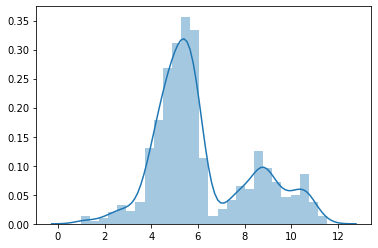

In [112]:
# Look at change of close some value. 
sns.distplot(matrix_3201[:,233]);

In [113]:
import random
ticker_index1, ticker_index2, ticker_index3 = random.sample(range(0, len(tickers_3201)), 3)
print("The three tickers chosen: {}, {}, {}".format(
    tickers_3201[ticker_index1], tickers_3201[ticker_index2], tickers_3201[ticker_index3]))

The three tickers chosen: utg, nni, mmlp


## Plot the close for the three tickers chosen

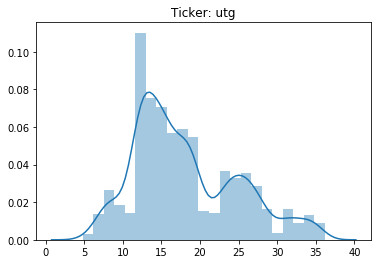

In [114]:
sns.distplot(matrix_3201[:,ticker_index1 * 5 + 3]).set_title("Ticker: {}".format(tickers_3201[ticker_index1]));

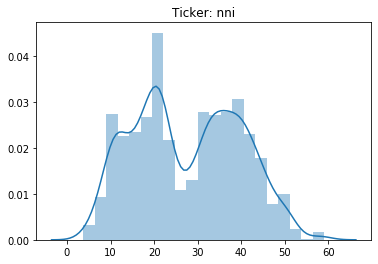

In [115]:
sns.distplot(matrix_3201[:,ticker_index2 * 5 + 3]).set_title("Ticker: {}".format(tickers_3201[ticker_index2]));

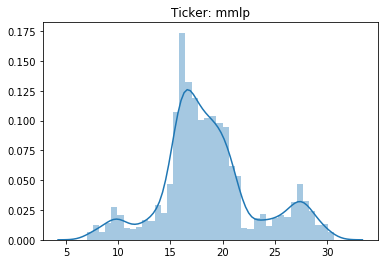

In [116]:
sns.distplot(matrix_3201[:,ticker_index3 * 5 + 3]).set_title("Ticker: {}".format(tickers_3201[ticker_index3]));

# Training of different models.

## Train for ticker ixc

In [120]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [117]:
# Delete close for ticker.
train_set = np.delete(matrix_3201[train_indicies], ticker_index1 * 5 + 3, 1)
train_target = matrix_3201[train_indicies][:, ticker_index1 * 5 + 3]
test_set = np.delete(matrix_3201[test_indicies], ticker_index1 * 5 + 3, 1)
test_target = matrix_3201[test_indicies][:, ticker_index1 * 5 + 3]

In [119]:
# Shape of the sets
print(train_set.shape)
print(train_target.shape)
print(test_set.shape)
print(test_target.shape)

(1600, 9134)
(1600,)
(1601, 9134)
(1601,)


In [249]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=train_set.shape[1], activation='relu'))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(40, activation='relu'))
    # model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_absolute_percentage_error', 
              metrics =[metrics.mape])
    return model

In [250]:
model = create_model()
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 10)                91350     
_________________________________________________________________
dense_67 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_68 (Dense)             (None, 40)                2040      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 41        
Total params: 93,981
Trainable params: 93,981
Non-trainable params: 0
_________________________________________________________________


In [251]:
history = model.fit(train_set, train_target, validation_data=(test_set, test_target), epochs=20, batch_size=32)

Train on 1600 samples, validate on 1601 samples
Epoch 1/20
1600/1600 [==============================] - 0s 218us/step - loss: 79.8347 - mean_absolute_percentage_error: 79.8347 - val_loss: 58.5744 - val_mean_absolute_percentage_error: 58.5744
Epoch 2/20
1600/1600 [==============================] - 0s 129us/step - loss: 39.3518 - mean_absolute_percentage_error: 39.3518 - val_loss: 29.2201 - val_mean_absolute_percentage_error: 29.2201
Epoch 3/20
1600/1600 [==============================] - 0s 119us/step - loss: 29.0669 - mean_absolute_percentage_error: 29.0669 - val_loss: 29.2455 - val_mean_absolute_percentage_error: 29.2455
Epoch 4/20
1600/1600 [==============================] - 0s 145us/step - loss: 28.9985 - mean_absolute_percentage_error: 28.9985 - val_loss: 29.2450 - val_mean_absolute_percentage_error: 29.2449
Epoch 5/20
1600/1600 [==============================] - 0s 122us/step - loss: 28.9159 - mean_absolute_percentage_error: 28.9159 - val_loss: 29.2937 - val_mean_absolute_percenta

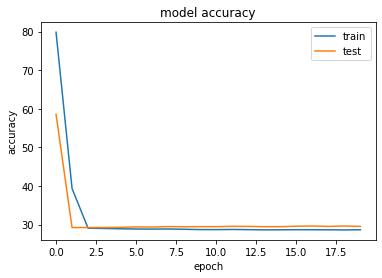

In [252]:
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.ylim(20, 2000)
#plt.xlim(10,)
plt.show()

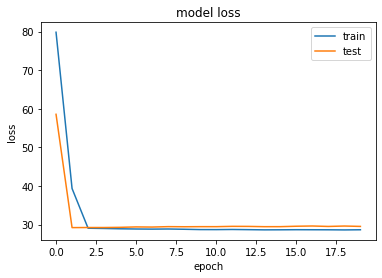

In [253]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.ylim(20, 2000)
plt.show()

In [254]:
prediction = model.predict(test_set)

(-1, 1680.0)

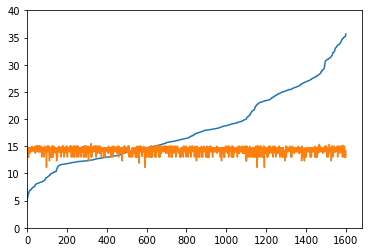

In [255]:
plt.plot(test_target)
plt.plot(prediction)

plt.ylim(0, 40)
plt.xlim(-1,)

In [256]:
prediction

array([[14.135569],
       [14.135569],
       [13.993702],
       ...,
       [13.012482],
       [13.012482],
       [14.135571]], dtype=float32)